In [925]:
import sys
import os

sys.path.append('../')

import pandas as pd
import numpy as np
from util import util
import importlib as imp
imp.reload(util)
from util import globalvar as gv
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder




In [926]:
file_name = '../Clean/ready_to_analyse.csv'
dtype_dict = {gv.ORI_STATE: 'category',\
                   gv.DEST_STATE: 'category',  gv.CANCELLED: 'boolean', gv.CANCELLATION_CODE: 'category',\
                    gv.DIVERTED: 'boolean', gv.SCHEDULED_ELAPSED_TIME: 'int64', gv.DISTANCE: 'int64',\
                    gv.DIV_AIRPORT_LANDINGS: 'category',  gv.DIV_REACH_DEST: 'boolean'}

df = pd.read_csv(file_name, dtype=dtype_dict,parse_dates=[gv.FLIGHT_DATE])

df[gv.SCHEDULED_DEP_TIME]=pd.to_datetime(df[gv.SCHEDULED_DEP_TIME],format='%H:%M:%S')
df[gv.SCHEDULED_ARR_TIME]=pd.to_datetime(df[gv.SCHEDULED_ARR_TIME], format='%H:%M:%S')

In [927]:

total_flights = df.shape[0]
no_of_flights_for_each_airline = df.groupby(gv.REPORTING_AIRLINE).count().sort_values(gv.FLIGHT_DATE, ascending=False)[gv.FLIGHT_DATE]
print(no_of_flights_for_each_airline)
    

reporting_airline
WN    194737
AA    144732
DL    138898
OO    132218
UA     96753
YX     55141
MQ     45171
9E     43025
B6     40806
OH     40262
NK     35426
AS     33778
YV     26156
F9     25963
G4     19338
QX     15085
HA     11955
Name: flight_date, dtype: int64


In [928]:

delayed_flights_with_no_reason = df.loc[(df[gv.ARR_DELAY_TIME]>=15)&(df[gv.CARRIER_DELAY].isna()) & (df[gv.WEATHER_DELAY].isna()) \
                                            &(df[gv.SECURITY_DELAY].isna())& (df[gv.NAS_DELAY].isna())& (df[gv.DIV_ARR_DELAY].isna())& (df[gv.LATE_AIRCRAFT_DELAY].isna())]

print(delayed_flights_with_no_reason[delayed_flights_with_no_reason[gv.REPORTING_AIRLINE]=='AA'])

Empty DataFrame
Columns: [flight_date, reporting_airline, flight_number, ori_airport, ori_city, ori_state, dest_airport, dest_city, dest_state, scheduled_dep_time, dep_delay_time(mins), gate_takeoff_gap(mins), land_gate_gap(mins), scheduled_arr_time, arr_delay_time(mins), cancelled, cancellation_code, diverted, scheduled_elapsed_time(mins), distance(miles), carrier_delay(mins), weather_delay(mins), nas_delay(mins), security_delay(mins), late_aircraft_delay(mins), div_airport_landings, div_reach_dest, diverted_delay(mins)]
Index: []

[0 rows x 28 columns]


In [929]:
#aa delay profile
aa_delay_profile = df.loc[(df[gv.REPORTING_AIRLINE]=='AA')&(df[gv.ARR_DELAY_TIME]>=15)]
print(aa_delay_profile[gv.ARR_DELAY_TIME].describe())
#wn delay profile
wn_delay_profile = df.loc[(df[gv.REPORTING_AIRLINE]=='WN')&(df[gv.ARR_DELAY_TIME]>=15)]
print(wn_delay_profile[gv.ARR_DELAY_TIME].describe())
#industry delay profile
industry_delay_profile = df.loc[(df[gv.ARR_DELAY_TIME]>=15)]
print(industry_delay_profile[gv.ARR_DELAY_TIME].describe())


count    22963.000000
mean        68.820320
std        121.118576
min         15.000000
25%         23.000000
50%         37.000000
75%         69.000000
max       2976.000000
Name: arr_delay_time(mins), dtype: float64
count    45885.000000
mean        47.478065
std         41.876057
min         15.000000
25%         22.000000
50%         33.000000
75%         56.000000
max        607.000000
Name: arr_delay_time(mins), dtype: float64
count    202492.000000
mean         63.741051
std          93.104243
min          15.000000
25%          23.000000
50%          37.000000
75%          69.000000
max        2976.000000
Name: arr_delay_time(mins), dtype: float64


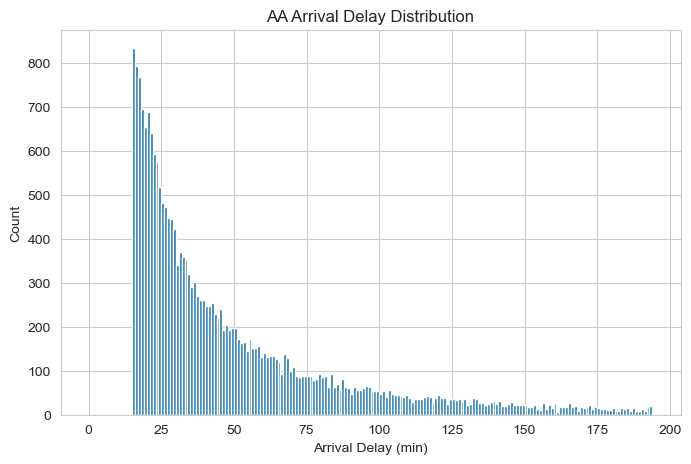

In [930]:
aa_delay_profile_95 = aa_delay_profile[aa_delay_profile[gv.ARR_DELAY_TIME]<aa_delay_profile[gv.ARR_DELAY_TIME].quantile(0.95)]

binsize = 1
bins = np.arange(0, aa_delay_profile_95[gv.ARR_DELAY_TIME].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = aa_delay_profile_95, x = gv.ARR_DELAY_TIME, bins = bins)
plt.xlabel('Arrival Delay (min)')
plt.ylabel('Count')
plt.title('AA Arrival Delay Distribution')
plt.show()


carrier_delay(mins)
count    15697.000000
mean        44.091228
std        112.605492
min          1.000000
25%          8.000000
50%         19.000000
75%         42.000000
max       2976.000000
Name: carrier_delay(mins), dtype: float64

weather_delay(mins)
count    430.000000
mean      47.693023
std       81.382253
min        1.000000
25%       10.000000
50%       20.000000
75%       43.000000
max      672.000000
Name: weather_delay(mins), dtype: float64

nas_delay(mins)
count    9690.000000
mean       17.605676
std        18.404712
min         1.000000
25%         6.000000
50%        15.000000
75%        22.000000
max       563.000000
Name: nas_delay(mins), dtype: float64

security_delay(mins)
count    283.000000
mean      23.893993
std       21.782681
min        1.000000
25%       10.000000
50%       17.000000
75%       30.000000
max      136.000000
Name: security_delay(mins), dtype: float64

late_aircraft_delay(mins)
count    10882.000000
mean        57.084084
std         86.93374

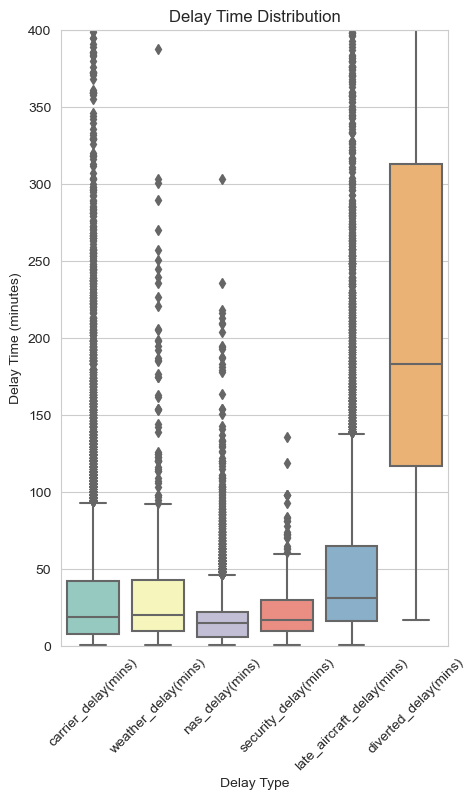

In [931]:
#AA airline delay causes analysis
util.plot_delay_component_boxplot(df,'AA')

Industry-wide delay rate: 18.42% aa delay rate: 15.87% wn delay rate: 23.56%


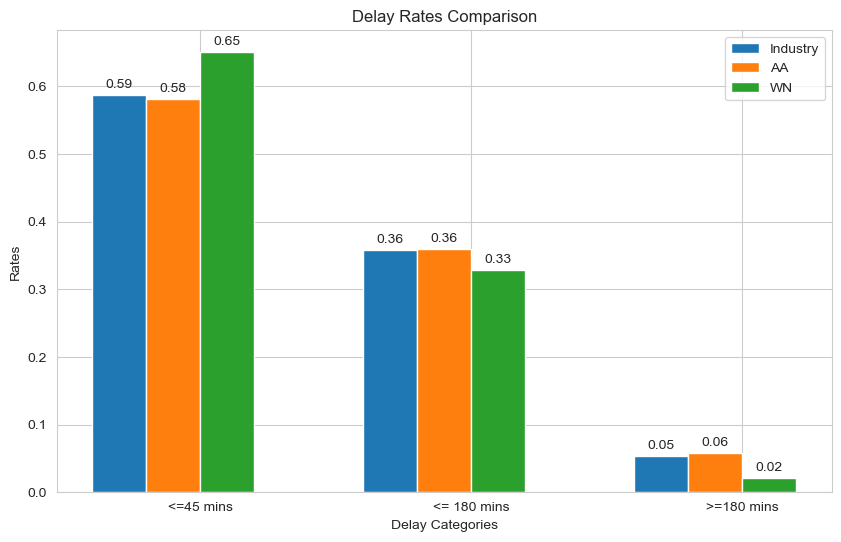

In [932]:
#competitor is WN, AA ranked as 2nd 
#Assume 15mins can be counted as delay
#45mins can be counted as long delay, 180mins can be counted as very long delay
SHORT_DELAY = 15
LONG_DELAY = 45
VERY_LONG_DELAY = 180

# Industry-wide rates
ind_rates = list(util.calculate_delay_rates(df))
ind_ttl_rate = ind_rates[0]
ind_detailed_rates = ind_rates[1:]

# AA rates
aa_rates = list(util.calculate_delay_rates(df, 'AA'))
aa_ttl_rate = aa_rates[0]
aa_detailed_rates = aa_rates[1:]
# WN rates
wn_rates = list(util.calculate_delay_rates(df, 'WN'))
wn_ttl_rate = wn_rates[0]
wn_detailed_rates = wn_rates[1:]
print('Industry-wide delay rate: {:.2%}'.format(ind_ttl_rate), 'aa delay rate: {:.2%}'.format(aa_ttl_rate), 'wn delay rate: {:.2%}'.format(wn_ttl_rate))

# Data preparation


delay_rates_data = [ind_detailed_rates, aa_detailed_rates, wn_detailed_rates]
delay_rates_categories = ['<=45 mins', '<= 180 mins', '>=180 mins']
util.create_bar_chart(delay_rates_data, delay_rates_categories, 'Delay Rates Comparison', 'Delay Categories', 'Rates', ['Industry', 'AA', 'WN'])

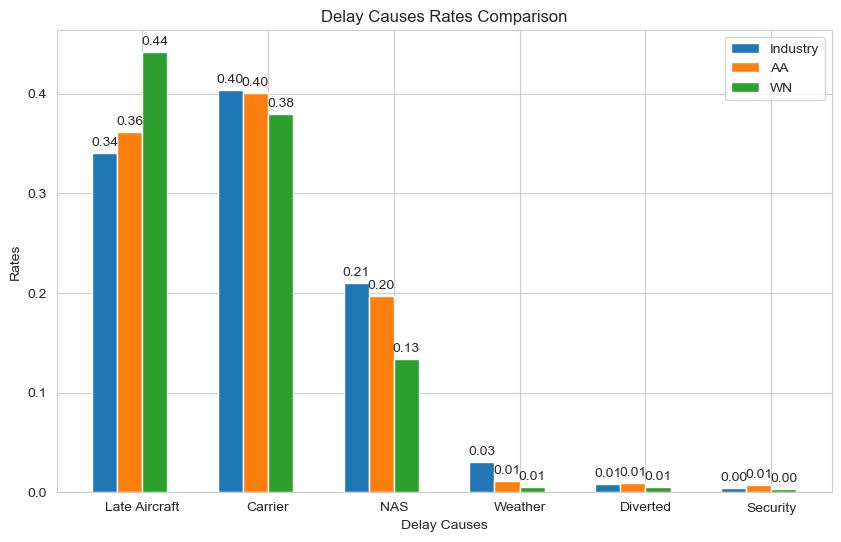

In [933]:
ind_delayed_causes_rates = list(util.calculate_delay_cause_rates(df))
aa_delayed_causes_rates = list(util.calculate_delay_cause_rates(df, 'AA'))
wn_delayed_causes_rates = list(util.calculate_delay_cause_rates(df, 'WN'))

#print(ind_delayed_causes_rates, aa_delayed_causes_rates, wn_delayed_causes_rates)

delay_causes_data = [ind_delayed_causes_rates, aa_delayed_causes_rates, wn_delayed_causes_rates]
delay_causes_categories = ['Late Aircraft', 'Carrier','NAS', 'Weather','Diverted','Security']
util.create_bar_chart(delay_causes_data, delay_causes_categories, 'Delay Causes Rates Comparison', 'Delay Causes', 'Rates', ['Industry', 'AA', 'WN'])


In [934]:
aa_dealy_cause_hours = util.calculate_hours_lost_under_each_cause(df, 'AA')

Carrier delay: 11535.00 hours Weather delay: 341.80 hours NAS delay: 2843.32 hours Security delay: 112.70 hours Late aircraft delay: 10353.15 hours Diverted delay: 1152.72 hours Total delay: 26338.68 hours


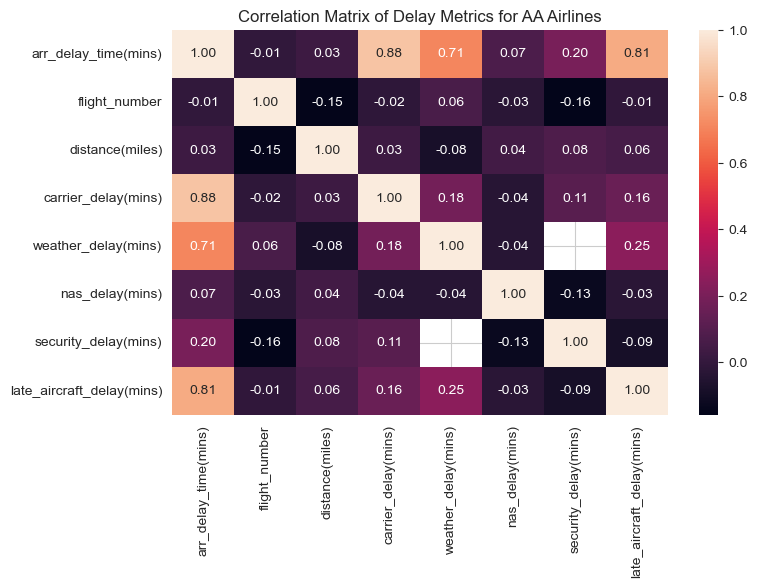

'\nplt.figure(figsize=[8, 5])\ncorrmat = df_aa.corr()\nsns.heatmap(corrmat, annot=True, fmt=".2f")\nplt.title(\'Correlation Matrix of Delay Metrics for AA Airlines\')\n'

In [935]:
df_aa = df.loc[(df[gv.REPORTING_AIRLINE]=='AA')&(df[gv.ARR_DELAY_TIME]>=15)]
plt.figure(figsize=[8, 5])
sns.heatmap(df_aa[[gv.ARR_DELAY_TIME,gv.FLIGHT_NUMBER,gv.DISTANCE,gv.CARRIER_DELAY,gv.WEATHER_DELAY,gv.NAS_DELAY,gv.SECURITY_DELAY,gv.LATE_AIRCRAFT_DELAY]].corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix of Delay Metrics for AA Airlines')
plt.show()
'''
plt.figure(figsize=[8, 5])
corrmat = df_aa.corr()
sns.heatmap(corrmat, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Delay Metrics for AA Airlines')
'''

In [936]:
# Perform ANOVA
df_aa = df.loc[(df[gv.REPORTING_AIRLINE]=='AA')&(df[gv.ARR_DELAY_TIME]>=15)]
df_aa = df_aa.rename(columns={'arr_delay_time(mins)': 'arr_delay_time_mins'})
#print(df_aa['ori_state'].value_counts())
# Adjusting the column names in the formula
for i in ['ori_state','ori_city','ori_airport','dest_state','dest_city','dest_airport']:
    df_aa[i] = df_aa[i].astype('category')
    model = ols(f'arr_delay_time_mins ~ C({i})', data=df_aa).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)

c:\Users\1997b\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 52, but rank is 43
  warnings.warn('covariance of constraints does not have full '


                    sum_sq       df         F        PR(>F)
C(ori_state)  5.537657e+06     52.0  7.345673  7.075260e-43
Residual      3.322667e+08  22919.0       NaN           NaN
                   sum_sq       df         F        PR(>F)
C(ori_city)  8.011474e+06    107.0  5.203944  5.129461e-61
Residual     3.288344e+08  22855.0       NaN           NaN
                      sum_sq       df         F        PR(>F)
C(ori_airport)  8.179473e+06    110.0  5.170131  5.409126e-62
Residual        3.286664e+08  22852.0       NaN           NaN
                     sum_sq       df         F        PR(>F)
C(dest_state)  1.980015e+06     52.0  2.603428  4.962013e-08
Residual       3.352085e+08  22919.0       NaN           NaN


c:\Users\1997b\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 52, but rank is 43
  warnings.warn('covariance of constraints does not have full '


                    sum_sq       df         F        PR(>F)
C(dest_city)  3.977920e+06    107.0  2.552593  2.344674e-16
Residual      3.328679e+08  22855.0       NaN           NaN
                       sum_sq       df         F        PR(>F)
C(dest_airport)  4.053515e+06    110.0  2.530405  1.969975e-16
Residual         3.327924e+08  22852.0       NaN           NaN


In [939]:
df_aa = df[(df[gv.REPORTING_AIRLINE]=='AA')&(df[gv.ARR_DELAY_TIME]>=15)]
X = df_aa[[gv.ORI_CITY, gv.ORI_AIRPORT, gv.ORI_STATE, gv.DEST_CITY, gv.DEST_AIRPORT, gv.DEST_STATE]]
y = df_aa[gv.ARR_DELAY_TIME]


# Manually label encode the categorical variable
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
lr = LinearRegression()

# Sequential Forward Selection
sfs = SFS(lr, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=0)

# Perform SFS
sfs = sfs.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[list(sfs.k_feature_idx_)]
print("Selected features:", selected_features)

# Evaluate the model on the test set
lr.fit(X_train[selected_features], y_train)
y_pred = lr.predict(X_test[selected_features])
print("Test set R-squared: ", r2_score(y_test, y_pred))

c:\Users\1997b\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: could not convert string to float: 'Washington'

In [897]:
#Perform linear regression
df_aa = df[(df[gv.REPORTING_AIRLINE]=='AA')&(df[gv.ARR_DELAY_TIME]>=15)]
y = df_aa[gv.ARR_DELAY_TIME]

# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_aa[[gv.ORI_CITY, gv.ORI_STATE]])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out([gv.ORI_CITY, gv.ORI_STATE]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

# Display coefficients
#coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
#print(coefficients)

Mean Squared Error: 18288.416408758912
R-squared: 0.009891130845362417
                       Coefficient
ori_city_Albany      -7.618857e+13
ori_city_Albuquerque -4.561725e+15
ori_city_Amarillo    -1.083892e+15
ori_city_Atlanta     -3.644217e+14
ori_city_Austin      -1.083892e+15
...                            ...
ori_state_Utah       -8.410999e+13
ori_state_Virginia   -6.544355e+14
ori_state_Washington -5.061011e+14
ori_state_Wisconsin  -3.311020e+13
ori_state_Wyoming    -1.096403e+14

[152 rows x 1 columns]


In [904]:
#Perform linear regression
df_aa = df[(df[gv.ARR_DELAY_TIME]>=15) & (df[gv.REPORTING_AIRLINE]=='AA')]
y = df_aa[gv.ARR_DELAY_TIME]

# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
for feature in [gv.ORI_CITY, gv.ORI_AIRPORT, gv.ORI_STATE, gv.DEST_CITY, gv.DEST_AIRPORT, gv.DEST_STATE,gv.DISTANCE]:
    X_encoded = encoder.fit_transform(df_aa[[feature]])
    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out([feature]))
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    # Initialize the model
    model = LinearRegression()
    # Fit the model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    # Evaluation
    print(f"{feature} Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print(f"{feature} R-squared:", r2_score(y_test, y_pred))
    # Display coefficients
    #coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
    #print(coefficients)



ori_city Mean Squared Error: 18280.54056965508
ori_city R-squared: 0.01031751757970023
ori_airport Mean Squared Error: 18286.329738358643
ori_airport R-squared: 0.01000410021483289
ori_state Mean Squared Error: 18277.657556973587
ori_state R-squared: 0.010473599788352494
dest_city Mean Squared Error: 3.6621115784890976e+25
dest_city R-squared: -1.982615155218901e+21
dest_airport Mean Squared Error: 4.637960565821049e+22
dest_airport R-squared: -2.510925926210639e+18
dest_state Mean Squared Error: 18435.992148377965
dest_state R-squared: 0.001901590067031278
distance(miles) Mean Squared Error: 18600.630425205476
distance(miles) R-squared: -0.007011692223018784


C:\Users\1997b\AppData\Local\Temp\ipykernel_15212\2985711677.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\1997b\AppData\Local\Temp\ipykernel_15212\2985711677.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\1997b\AppData\Local\Temp\ipykernel_15212\2985711677.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\1997b\AppData\Local\Temp\ipykernel_15212\2985711677.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\1997b\AppData\Local\Temp\ipykernel_15212\2985711677.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


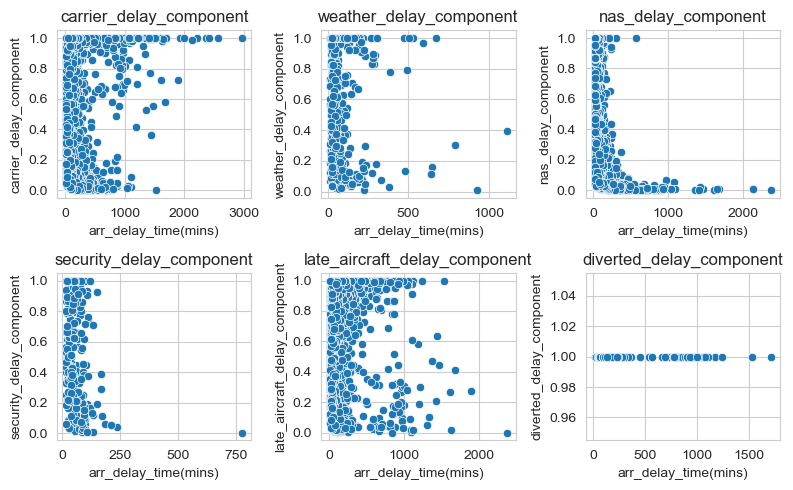

In [810]:
df_delay_component_analysis = util.component_rate_of_delay(df, 'AA')


causes = ['carrier_delay_component', 'weather_delay_component', 'nas_delay_component', 'security_delay_component', 'late_aircraft_delay_component', 'diverted_delay_component']

#x_min = df_delay_component_analysis[gv.ARR_DELAY_TIME].min()
#x_max = df_delay_component_analysis[gv.ARR_DELAY_TIME].max()

n_rows = 2
n_cols = 3

plt.figure(figsize=(8,5))  

for i, cause in enumerate(causes, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=gv.ARR_DELAY_TIME, y=cause, data=df_delay_component_analysis)
    plt.title(cause)
    #plt.xlim(x_min, x_max)
    plt.tight_layout()  

plt.show()

In [811]:
most_delayed_route_airport = util.most_delayed_route(df,'AA')[0]
most_delayed_route_city = util.most_delayed_route(df,'AA')[1]
most_delayed_route_state = util.most_delayed_route(df,'AA')[2]


print(most_delayed_route_airport)
print(most_delayed_route_city)
print(most_delayed_route_airport)

                          delayed_flights  total_flights  delayed_rate
ori_airport dest_airport                                              
LAX         MIA                       171            420      0.407143
MIA         LAX                       170            419      0.405728
            SJU                       136            346      0.393064
            JFK                       182            524      0.347328
            ATL                       107            392      0.272959
                         delayed flights  total flights  delayed rate
ori_city    dest_city                                                
Los Angeles Miami                    171            420      0.407143
Miami       Los Angeles              170            419      0.405728
            San Juan                 136            346      0.393064
            New York                 401           1331      0.301277
            Atlanta                  107            392      0.272959
             

In [812]:
m = util.map_plotting(most_delayed_route_state)
m

In [813]:
m = util.map_plotting(most_delayed_route_city)
m

In [814]:
dep_city_delayed = util.dep_city_delayed_rate(df,'AA','city')
print(dep_city_delayed[0:5])
dep_airport_delayed = util.dep_city_delayed_rate(df,'AA','airport')
print(dep_airport_delayed[0:5])
dep_state_delayed = util.dep_city_delayed_rate(df,'AA','state')
print(dep_state_delayed[0:5])


ori_city
Key West          0.390449
Miami             0.263312
Salt Lake City    0.252205
Newark            0.211966
Indianapolis      0.207407
Name: count, dtype: float64
ori_airport
EYW    0.390449
MIA    0.263312
SLC    0.252205
EWR    0.211966
IND    0.207407
Name: count, dtype: float64
ori_state
Utah          0.252205
New Jersey    0.211966
Indiana       0.207407
Florida       0.206048
Illinois      0.200362
Name: count, dtype: float64


In [815]:
dep_city_delayed_list = dep_city_delayed[0:5].index.tolist()
dep_airport_delayed_list = dep_airport_delayed[0:5].index.tolist()
dep_state_delayed_list = dep_state_delayed[0:5].index.tolist()

m = util.plot_city_on_map(dep_city_delayed_list)
m



In [816]:
m=util.highlight_state_on_map(dep_state_delayed_list)
m

c:\Users\1997b\DataScience\datacamp_project\flights\Analyse\..\util\util.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_df['flight_weekday'] = flights_df[gv.FLIGHT_DATE].dt.weekday
c:\Users\1997b\DataScience\datacamp_project\flights\Analyse\..\util\util.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_df_delayed['flight_weekday'] = flights_df_delayed[gv.FLIGHT_DATE].dt.weekday
c:\Users\1997b\DataScience\datacamp_project\flights\Analyse\..\util\util.py:210: SettingWithCopyWarning:

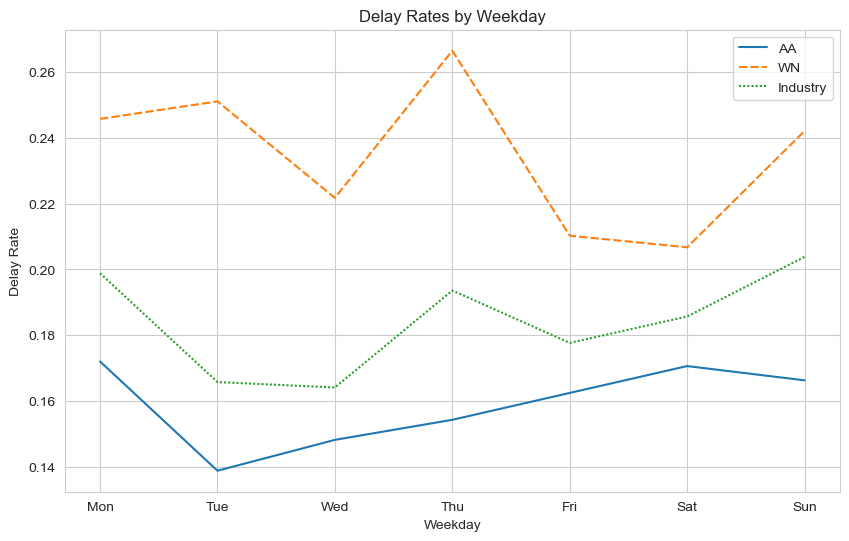

In [817]:

aa_weekday_delay_rate = util.most_delayed_analysis(df,'weekday','AA')
wn_weekday_delay_rate = util.most_delayed_analysis(df,'weekday','WN')
industry_weekday_delay_rate = util.most_delayed_analysis(df,'weekday')

data = {'AA': aa_weekday_delay_rate, 'WN': wn_weekday_delay_rate, 'Industry': industry_weekday_delay_rate}
df_plot = pd.DataFrame(data)
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_plot)
plt.title('Delay Rates by Day')
plt.xlabel('Day')
plt.ylabel('Delay Rate')
plt.legend(title='Airline')
plt.legend()
plt.title('Delay Rates by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Delay Rate')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


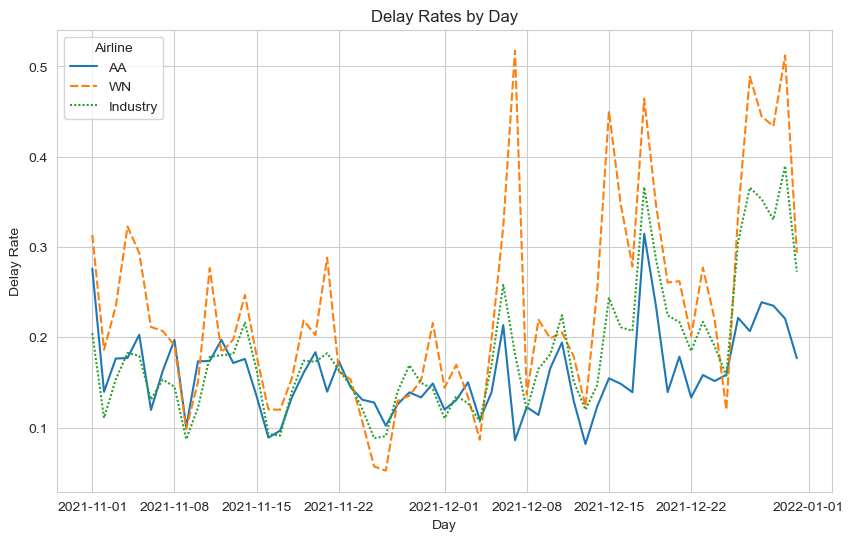

In [818]:
aa_daily_delayed_rate = util.most_delayed_analysis(df,'day','AA')
wn_daily_delayed_rate = util.most_delayed_analysis(df,'day','WN')
industry_daily_delayed_rate = util.most_delayed_analysis(df,'day')

data = {
    'AA': aa_daily_delayed_rate,
    'WN': wn_daily_delayed_rate,
    'Industry': industry_daily_delayed_rate
}
df_plot = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot)
plt.title('Delay Rates by Day')
plt.xlabel('Day')
plt.ylabel('Delay Rate')
plt.legend(title='Airline')
plt.show()



c:\Users\1997b\DataScience\datacamp_project\flights\Analyse\..\util\util.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_df['flight_hour'] = flights_df[gv.SCHEDULED_DEP_TIME].dt.hour
c:\Users\1997b\DataScience\datacamp_project\flights\Analyse\..\util\util.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_df_delayed['flight_hour'] = flights_df_delayed[gv.SCHEDULED_DEP_TIME].dt.hour
c:\Users\1997b\DataScience\datacamp_project\flights\Analyse\..\util\util.py:222: SettingWithCopyWarnin

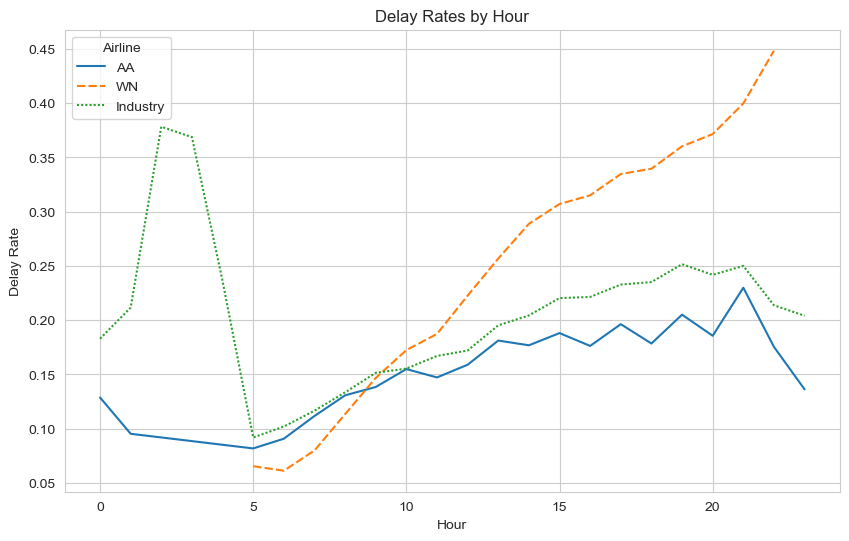

In [819]:
aa_hour_delayed_rate = util.most_delayed_analysis(df,'hour','AA')
wn_hour_delayed_rate = util.most_delayed_analysis(df,'hour','WN')
industry_hour_delayed_rate = util.most_delayed_analysis(df,'hour')

data = {
    'AA': aa_hour_delayed_rate,
    'WN': wn_hour_delayed_rate,
    'Industry': industry_hour_delayed_rate
}
df_plot = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot)
plt.title('Delay Rates by Hour')
plt.xlabel('Hour')
plt.ylabel('Delay Rate')
plt.legend(title='Airline')
plt.show()
